In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/My\ Drive/CPN Dataset

/content/drive/My Drive/CPN Dataset


In [3]:
ls

 CPN_Model.h5         Dataset/        plot1.png
 CPN_Model_VGG16.h5  'New Dataset'/   plot.png


In [ ]:
import os
import numpy as np
import shutil
import pandas as pd


def train_test_split():
    print("########### Train Test Val Script started ###########")

    root_dir='/content/drive/My Drive/CPN Dataset/New Dataset'

    classes_dir=['COVID', 'Normal', 'Viral Pneumonia']

    processed_dir='/content/drive/My Drive/CPN Dataset/Dataset'

    val_ratio=0.20
    test_ratio=0.20

    for cls in classes_dir:
        # creating partitions of the data after shuffeling
        print("$$$$$$$ Class Name " + cls + " $$$$$$$")
        src = processed_dir +"/" + cls  # folder to copy images from

        allFileNames=os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames=np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                                   int(len(allFileNames) * (1 - val_ratio)),
                                                                   ])

        train_FileNames=[src + '/' + name for name in train_FileNames.tolist()]
        val_FileNames=[src + '/' + name for name in val_FileNames.tolist()]
        test_FileNames=[src + '/' + name for name in test_FileNames.tolist()]

        print('Total images: '+ str(len(allFileNames)))
        print('Training: '+ str(len(train_FileNames)))
        print('Validation: '+  str(len(val_FileNames)))
        print('Testing: '+ str(len(test_FileNames)))

        # creating train / val / test folders (one time use)
        os.makedirs(root_dir + '/train/' + cls)
        os.makedirs(root_dir + '/val/' + cls)
        os.makedirs(root_dir + '/test/' + cls)

        # copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, root_dir + '/train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, root_dir + '/val/' + cls)

        for name in test_FileNames:
            shutil.copy(name, root_dir + '/test/' + cls)

    print("########### Train Test Val Script Ended ###########")

train_test_split()

########### Train Test Val Script started ###########
$$$$$$$ Class Name COVID $$$$$$$
Total images: 3616
Training: 2169
Validation: 723
Testing: 724
$$$$$$$ Class Name Normal $$$$$$$
Total images: 4990
Training: 2994
Validation: 998
Testing: 998
$$$$$$$ Class Name Viral Pneumonia $$$$$$$
Total images: 1345
Training: 807
Validation: 269
Testing: 269
########### Train Test Val Script Ended ###########


**TRAINING/TESTING MODEL**

In [4]:
# libraries required to train the model
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [5]:
#path to get images
train_path='/content/drive/My Drive/CPN Dataset/New Dataset/train/'
val_path='/content/drive/My Drive/CPN Dataset/New Dataset/val/'
test_path='/content/drive/My Drive/CPN Dataset/New Dataset/test/'

In [6]:
#re-size all the images to a size VGG-16 expects.
img_size=[224, 224]

#set the batch size
batch_size=32  #try reducing batch size or freeze more layers if your GPU runs out of memory
no_epochs=5
lr=0.0001
no_classes=3

In [7]:
import os

classes=os.listdir(train_path)
no_classes=len(classes)

In [8]:
print("Class --> {} \n and the length is : {}".format(classes, no_classes))

Class --> ['COVID', 'Normal', 'Viral Pneumonia'] 
 and the length is : 3


In [9]:
#image data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [10]:
#import the images from the train dataset
#make sure to provide the same target size as initialied for the image size
training_set=train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5970 images belonging to 3 classes.


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
#import the images from the test dataset.

test_set=test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1991 images belonging to 3 classes.


In [ ]:
#import the VGG 16 library as shown below and add preprocessing layer to the front of VGG
#here we will be using imagenet weights

vgg = VGG16(input_shape=img_size+[3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
#don't train existing weights
for layer in vgg.layers:
    layer.trainable=False

In [ ]:
#our layers - you can add more if you want
x=Flatten()(vgg.output)

prediction=Dense(no_classes, activation='softmax')(x)

In [ ]:
#create a model object
model=Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
#fit the model
history=model.fit(
    training_set, 
    validation_data=test_set, 
    epochs=5, 
    steps_per_epoch=len(training_set), 
    validation_steps=len(test_set)
    )

Epoch 1/5
187/187 [==============================] - 1560s 8s/step - loss: 0.4948 - accuracy: 0.8074 - val_loss: 0.2637 - val_accuracy: 0.9026
Epoch 2/5
187/187 [==============================] - 110s 590ms/step - loss: 0.2888 - accuracy: 0.8838 - val_loss: 0.2730 - val_accuracy: 0.9036
Epoch 3/5
187/187 [==============================] - 109s 583ms/step - loss: 0.2590 - accuracy: 0.9015 - val_loss: 0.1984 - val_accuracy: 0.9272
Epoch 4/5
187/187 [==============================] - 109s 584ms/step - loss: 0.1932 - accuracy: 0.9281 - val_loss: 0.2872 - val_accuracy: 0.9011
Epoch 5/5
187/187 [==============================] - 110s 588ms/step - loss: 0.2326 - accuracy: 0.9136 - val_loss: 0.2184 - val_accuracy: 0.9176


In [ ]:
#generate Validation set
validation_datagen=ImageDataGenerator(rescale=1./255)

validation_set=validation_datagen.flow_from_directory(
    directory=val_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1990 images belonging to 3 classes.


In [ ]:
#just capture the loss and accuray into val variable
validation_steps=20

loss,accuracy=model.evaluate(validation_set, steps=validation_steps)

print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

20/20 [==============================] - 110s 6s/step - loss: 0.2242 - accuracy: 0.9125
loss: 0.22
accuracy: 0.91


In [ ]:
model.save('/content/drive/My Drive/CPN Dataset/CPN_Model_VGG16.h5')

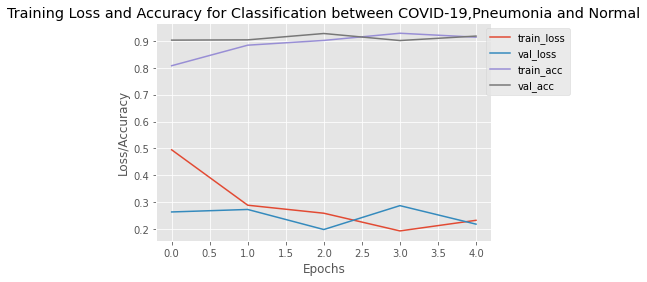

In [ ]:
#loss/accuracy graph
n=no_epochs
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, n), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, n), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy for Classification between COVID-19,Pneumonia and Normal")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("plot1.png")

In [ ]:
#to check test accuacy
modelLoss, modelAccuracy=model.evaluate(test_set, verbose=0)

print('Test Loss is: {}'.format(modelLoss))
print('Test Accuracy is: {}'.format(modelAccuracy ))

Test Loss is: 0.21836653351783752
Test Accuracy is: 0.9176293611526489


**PREDICTING THE OUTPUT**

In [22]:
#loading the model
from tensorflow import keras
model=keras.models.load_model('/content/drive/MyDrive/CPN Dataset/CPN_Model_VGG16.h5')

In [23]:
#get sample image to test
img_normal=image.load_img('/content/drive/My Drive/CPN Dataset/Dataset/Normal/Normal-500.png', target_size=(224, 224))
img_pneumonia=image.load_img('/content/drive/MyDrive/CPN Dataset/Dataset/Viral Pneumonia/Viral Pneumonia-1000.png', target_size=(224, 224))
img_covid=image.load_img('/content/drive/MyDrive/CPN Dataset/Dataset/COVID/COVID-19.png', target_size=(224, 224))

In [24]:
def model_predict(img, actual):
    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    x_processed=preprocess_input(x)
    result=model.predict(x_processed)
    index = np.argmax(result,axis=1)
    if index==0:
       result="covid-19"
    elif index==1:
       result="normal"
    else:
       result="pneumonia"

    plt.figure()
    plt.imshow(img)
    plt.title('Actual : {} --> Predicted  : {}'.format(actual, result))

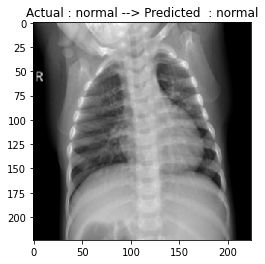

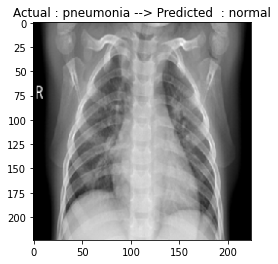

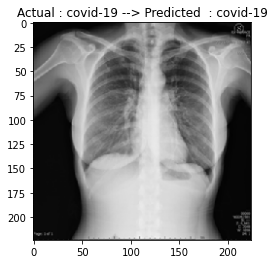

In [25]:
pred_normal=model_predict(img_normal, "normal")
pred_pneumonia=model_predict(img_pneumonia, "pneumonia")
pred_covid=model_predict(img_covid, "covid-19")